In [1]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from astroML.datasets import fetch_LINEAR_geneva


In [2]:
#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
# if "setup_text_plots" not in globals():
#     from astroML.plotting import setup_text_plots
# setup_text_plots(fontsize=8, usetex=True)

data = fetch_LINEAR_geneva()

attributes = [('gi', 'logP'),
              ('gi', 'logP', 'ug', 'iK', 'JK', 'amp', 'skew')]
labels = ['$u-g$', '$g-i$', '$i-K$', '$J-K$',
          r'$\log(P)$', 'amplitude', 'skew']
cls = 'LCtype'
Ntrain = 3000



In [3]:
#------------------------------------------------------------
# Create attribute arrays
X = []
y = []

for attr in attributes:
    X.append(np.vstack([data[a] for a in attr]).T)
    LCtype = data[cls].copy()

    # there is no #3.  For a better color scheme in plots,
    # we'll set 6->3
    LCtype[LCtype == 6] = 3
    y.append(LCtype)


In [4]:
#@pickle_results('LINEAR_SVM.pkl')
def compute_SVM_results(i_train, i_test):
    classifiers = []
    predictions = []
    Xtests = []
    ytests = []
    Xtrains = []
    ytrains = []

    for i in range(len(attributes)):
        Xtrain = X[i][i_train]
        Xtest = X[i][i_test]
        ytrain = y[i][i_train]
        ytest = y[i][i_test]

        clf = SVC(kernel='linear', class_weight=None)
        clf.fit(Xtrain, ytrain)
        y_pred = clf.predict(Xtest)

        classifiers.append(clf)
        predictions.append(y_pred)

    return classifiers, predictions



In [5]:
i = np.arange(len(data))
i_train, i_test = train_test_split(i, random_state=0, train_size=2000)
clfs, ypred = compute_SVM_results(i_train, i_test)

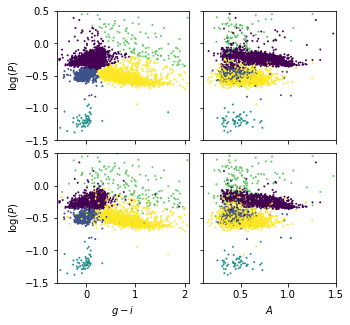

In [6]:
#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

class_labels = []

for i in range(2):
    Xtest = X[i][i_test]
    ytest = y[i][i_test]
    amp = data['amp'][i_test]

    # Plot the resulting classifications
    ax1 = fig.add_subplot(221 + 2 * i)
    ax1.scatter(Xtest[:, 0], Xtest[:, 1],
                c=ypred[i], edgecolors='none', s=4, linewidths=0)

    ax1.set_ylabel(r'$\log(P)$')

    ax2 = plt.subplot(222 + 2 * i)
    ax2.scatter(amp, Xtest[:, 1],
                c=ypred[i], edgecolors='none', s=4, lw=0)

    #------------------------------
    # set axis limits
    ax1.set_xlim(-0.6, 2.1)
    ax2.set_xlim(0.1, 1.5)
    ax1.set_ylim(-1.5, 0.5)
    ax2.set_ylim(-1.5, 0.5)

    ax2.yaxis.set_major_formatter(plt.NullFormatter())
    if i == 0:
        ax1.xaxis.set_major_formatter(plt.NullFormatter())
        ax2.xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax1.set_xlabel(r'$g-i$')
        ax2.set_xlabel(r'$A$')


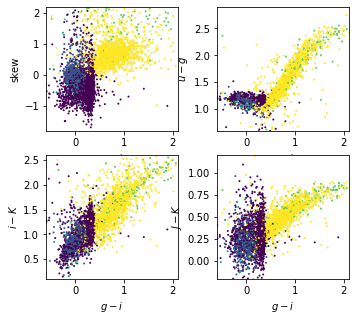

In [7]:
#------------------------------------------------------------
# Second figure
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0.11, right=0.95, wspace=0.3)

attrs = ['skew', 'ug', 'iK', 'JK']
labels = ['skew', '$u-g$', '$i-K$', '$J-K$']
ylims = [(-1.8, 2.2), (0.6, 2.9), (0.1, 2.6), (-0.2, 1.2)]

for i in range(4):
    ax = fig.add_subplot(221 + i)
    ax.scatter(data['gi'][i_test], data[attrs[i]][i_test],
               c=ypred[1], edgecolors='none', s=4, lw=0)
    ax.set_xlabel('$g-i$')
    ax.set_ylabel(labels[i])

    ax.set_xlim(-0.6, 2.1)
    ax.set_ylim(ylims[i])


In [8]:
#------------------------------------------------------------
# Save the results
#
# run the script as
#
#   >$ python fig_LINEAR_clustering.py --save
#
# to output the data file showing the cluster labels of each point
import sys
if len(sys.argv) > 1 and sys.argv[1] == '--save':
    filename = 'cluster_labels_svm.dat'

    print("Saving cluster labels to", filename)

    from astroML.datasets.LINEAR_sample import ARCHIVE_DTYPE
    new_data = np.zeros(len(data),
                        dtype=(ARCHIVE_DTYPE + [('2D_cluster_ID', 'i4'),
                                                ('7D_cluster_ID', 'i4')]))

    # switch the labels back 3->6
    for i in range(2):
        ypred[i][ypred[i] == 3] = 6

    # need to put labels back in order
    class_labels = [-999 * np.ones(len(data)) for i in range(2)]
    for i in range(2):
        class_labels[i][i_test] = ypred[i]

    for name in data.dtype.names:
        new_data[name] = data[name]
    new_data['2D_cluster_ID'] = class_labels[0]
    new_data['7D_cluster_ID'] = class_labels[1]

    fmt = ('%.6f   %.6f   %.3f   %.3f   %.3f   %.3f   %.7f   %.3f   %.3f   '
           '%.3f    %.2f     %i     %i      %s          %i              %i\n')


    F = open(filename, 'w')
    F.write('#    ra           dec       ug      gi      iK      JK     '
            'logP       Ampl    skew      kurt    magMed    nObs  LCtype  '
            'LINEARobjectID  2D_cluster_ID   7D_cluster_ID\n')
    for line in new_data:
        F.write(fmt % tuple(line[col] for col in line.dtype.names))
    F.close()

plt.show()